# Modelling

In [62]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
    f1_score
)
from xgboost import XGBClassifier

In [63]:
np.random.seed(42)

## Import data

In [64]:
data = pd.read_csv('../data/cleaned_engineered_data.csv')

In [65]:
data.columns

Index(['Partner', 'Dependents', 'MultipleLines', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'PaperlessBilling', 'Churn', 'new_customer',
       'is_autopay', 'AddOnCount', 'ChargePerMonthRatio',
       'Fiber_NoTechSupport', 'FiberOptic_StreamingTV', 'Senior_Contract',
       'M2M_ElectronicCheck', 'InternetService_DSL',
       'InternetService_Fiber optic', 'InternetService_No',
       'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year',
       'tenure_group_0–6', 'tenure_group_6–12', 'tenure_group_12–24',
       'tenure_group_24–48', 'tenure_group_48–60', 'tenure_group_60–72',
       'AddOnGroup_None', 'AddOnGroup_Low', 'AddOnGroup_High',
       'MonthlyCharges_group_Low', 'MonthlyCharges_group_Medium',
       'MonthlyCharges_group_High', 'MonthlyCharges_group_Very High'],
      dtype='object')

In [66]:
X = data.drop(columns=['Churn'])
y = data['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Baseline

This analysis implements a contract-based heuristic baseline for churn prediction, leveraging the relationship between customer contract duration and churn behavior. The approach uses data-driven thresholds rather than simple rule-based predictions

In [67]:
import plotly.express as px
contract_churn_rates = {}
for contract_type in ['Month-to-month', 'One year', 'Two year']:
    if f'Contract_{contract_type}' in X_train.columns:
        mask = X_train[f'Contract_{contract_type}'] == 1
        churn_rate = y_train[mask].mean()
        contract_churn_rates[contract_type] = churn_rate
        print(f"{contract_type} churn rate: {churn_rate:.3f}")

# Use the churn rates to set thresholds
# Predict churn if customer has contract type with churn rate > threshold
thresholds = np.linspace(0, 1, 100)
f1_scores = []

for t in thresholds:
    preds = np.zeros(len(X_test))
    
    for contract_type, churn_rate in contract_churn_rates.items():
        if churn_rate > t and f'Contract_{contract_type}' in X_test.columns:
            mask = X_test[f'Contract_{contract_type}'] == 1
            preds[mask] = 1
    
    f1 = f1_score(y_test, preds)
    f1_scores.append(f1)

fig = px.line(
    x=thresholds,
    y=f1_scores,
    labels={"x": "Churn Rate Threshold", "y": "F1 Score"},
    title="Contract-based Heuristic Baseline: Threshold vs F1 Score"
)
fig.show()

print(f"Best Contract F1 Score: {max(f1_scores):.3f}")

Month-to-month churn rate: 0.427
One year churn rate: 0.111
Two year churn rate: 0.029


Best Contract F1 Score: 0.574


Baseline Achievement:
- Best F1 Score: 0.574
- Optimal Threshold: 0.424

## Model

In [68]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

In [69]:
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [70]:
results = {}
scoring_metrics = ['roc_auc', 'f1', 'precision', 'recall']

for name, model in models.items():
    # Train on training set
    model.fit(X_train, y_train)
    
    # Perform cross-validation with multiple metrics
    cv_results = cross_validate(model, X_train, y_train, cv=5, scoring=scoring_metrics)
    
    results[name] = {
        'model': model,
        'cv_roc_auc': cv_results['test_roc_auc'].mean(),
        'cv_roc_auc_std': cv_results['test_roc_auc'].std(),
        'cv_f1': cv_results['test_f1'].mean(),
        'cv_f1_std': cv_results['test_f1'].std(),
        'cv_precision': cv_results['test_precision'].mean(),
        'cv_recall': cv_results['test_recall'].mean(),
        'cv_results': cv_results
    }
    
    print(f"{name}:")
    print(f"  ROC AUC: {cv_results['test_roc_auc'].mean():.4f} ± {cv_results['test_roc_auc'].std():.4f}")
    print(f"  F1:      {cv_results['test_f1'].mean():.4f} ± {cv_results['test_f1'].std():.4f}")
    print(f"  Precision: {cv_results['test_precision'].mean():.4f}")
    print(f"  Recall:    {cv_results['test_recall'].mean():.4f}")
    print()

# Select best model based on ROC AUC (you can change this criterion)
best_model_name = max(results.keys(), key=lambda x: results[x]['cv_roc_auc'])
best_model = results[best_model_name]['model']
best_scores = results[best_model_name]

print(f"Selected: {best_model_name}")
print(f'ROC AUC (avg 5-fold): {best_scores["cv_roc_auc"]:.4f}')
print(f'F1 Score (avg 5-fold): {best_scores["cv_f1"]:.4f}')

Logistic Regression:
  ROC AUC: 0.8479 ± 0.0148
  F1:      0.5846 ± 0.0295
  Precision: 0.6699
  Recall:    0.5191

Random Forest:
  ROC AUC: 0.8098 ± 0.0118
  F1:      0.5392 ± 0.0178
  Precision: 0.6021
  Recall:    0.4890



/Users/mewpunyapat/miniconda3/envs/datasci/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning:

[15:14:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


/Users/mewpunyapat/miniconda3/envs/datasci/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning:

[15:14:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


/Users/mewpunyapat/miniconda3/envs/datasci/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning:

[15:14:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


/Users/mewpunyapat/miniconda3/envs/datasci/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning:

[15:14:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


/Users/mewpunyapat/miniconda3/envs/datasci/l

XGBoost:
  ROC AUC: 0.8144 ± 0.0141
  F1:      0.5437 ± 0.0294
  Precision: 0.5929
  Recall:    0.5023

Selected: Logistic Regression
ROC AUC (avg 5-fold): 0.8479
F1 Score (avg 5-fold): 0.5846


Observations
- Logistic Regression is the selcted model, achieving ROC AUC score of 0.8479, and F1 score of 0.5846

Insights
- The F1 score is only slightly better than  heuristic baseline of 0.574, which suggests there's room for improvement in precision/recall balance
- The gap between your ROC AUC (0.8479) and F1 score (0.5846) indicates that:
    - The model is good at ranking predictions (ROC AUC) But there might be issues with the **classification threshold** or **class imbalance**

## Hyperparameter tuning

In [76]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],  
    'class_weight': [None, 'balanced'],
    'max_iter': [100, 300, 500, 1000]
}

grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score from CV:", grid_search.best_score_)

best_model = grid_search.best_estimator_

/Users/mewpunyapat/miniconda3/envs/datasci/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mewpunyapat/miniconda3/envs/datasci/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mewpunyapat/miniconda3/envs/datasci/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mewpunyapat/miniconda3/envs/datasci/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mewpunyapat/miniconda3/envs/datasci/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_

Best Parameters: {'C': 0.01, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}
Best F1 Score from CV: 0.6415785214732729


In [78]:
#Get probabilities from your best model
y_prob = best_model.predict_proba(X_test)[:, 1]

# Find optimal threshold for F1
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
f1_scores = f1_scores[:-1]  # Remove last element to match thresholds length

optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
max_f1 = f1_scores[optimal_idx]

print(f"Current F1 with default threshold (0.5): {f1_score(y_test, best_model.predict(X_test)):.4f}")
print(f"Optimal threshold: {optimal_threshold:.4f}")
print(f"Max possible F1 with threshold tuning: {max_f1:.4f}")
print(f"Potential F1 improvement: +{max_f1 - 0.5846:.4f}")

y_pred_final = (y_prob >= optimal_threshold).astype(int)

print(classification_report(y_test, y_pred_final))
print(confusion_matrix(y_test, y_pred_final))

Current F1 with default threshold (0.5): 0.6166
Optimal threshold: 0.4787
Max possible F1 with threshold tuning: 0.6297
Potential F1 improvement: +0.0451
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1035
           1       0.52      0.80      0.63       374

    accuracy                           0.75      1409
   macro avg       0.71      0.77      0.72      1409
weighted avg       0.81      0.75      0.76      1409

[[754 281]
 [ 73 301]]


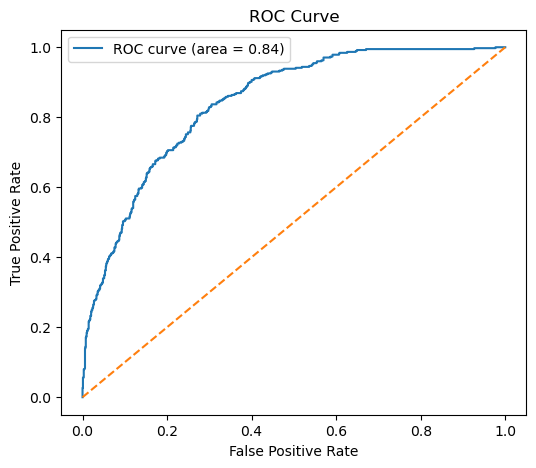

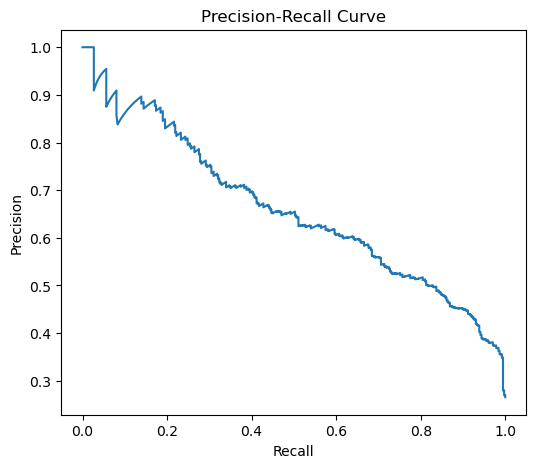

In [79]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curve')
plt.legend(); plt.show()

# Precision-Recall Curve
precisions, recalls, _ = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(recalls, precisions)
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall Curve')
plt.show()


In [80]:
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced']
}

rf = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(rf, rf_params, scoring='f1', cv=5, n_jobs=-1)
grid_rf.fit(X_train, y_train)

best_rf = grid_rf.best_estimator_
print("Best Parameters:", grid_rf.best_params_)

Best Parameters: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}


In [81]:
y_probs_rf = best_rf.predict_proba(X_test)[:, 1]

thresholds = np.arange(0.1, 0.9, 0.01)
f1_scores = [f1_score(y_test, y_probs_rf > t) for t in thresholds]

optimal_threshold_rf = thresholds[np.argmax(f1_scores)]
max_f1_rf = max(f1_scores)

print(f"Optimal Threshold: {optimal_threshold_rf:.4f}")
print(f"Max F1 Score: {max_f1_rf:.4f}")

y_pred_rf = (y_probs_rf > optimal_threshold_rf).astype(int)

print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))

Optimal Threshold: 0.4000
Max F1 Score: 0.6283
              precision    recall  f1-score   support

           0       0.92      0.71      0.80      1035
           1       0.50      0.83      0.63       374

    accuracy                           0.74      1409
   macro avg       0.71      0.77      0.71      1409
weighted avg       0.81      0.74      0.75      1409

[[730 305]
 [ 63 311]]


In [82]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=1035/374)
grid_xgb = GridSearchCV(xgb, param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=1)
grid_xgb.fit(X_train, y_train)

best_xgb = grid_xgb.best_estimator_
print("Best parameters:", grid_xgb.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/Users/mewpunyapat/miniconda3/envs/datasci/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:10:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/mewpunyapat/miniconda3/envs/datasci/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:10:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/mewpunyapat/miniconda3/envs/datasci/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:10:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/mewpunyapat/miniconda3/envs/datasci/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:10:00] WARNING: /Users/runner/work/xgboost/

Best parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}


/Users/mewpunyapat/miniconda3/envs/datasci/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning:

[18:10:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




In [83]:
y_probs = best_xgb.predict_proba(X_test)[:, 1]
prec, rec, thresholds = precision_recall_curve(y_test, y_probs)
f1_scores = 2 * (prec * rec) / (prec + rec)
best_thresh = thresholds[f1_scores.argmax()]
print(f"Optimal Threshold: {best_thresh:.4f}")
print(f"Max F1 Score: {f1_scores.max():.4f}")

y_pred_final = (y_probs >= best_thresh).astype(int)
print(classification_report(y_test, y_pred_final))
print(confusion_matrix(y_test, y_pred_final))

Optimal Threshold: 0.5759
Max F1 Score: 0.6306
              precision    recall  f1-score   support

           0       0.89      0.79      0.84      1035
           1       0.55      0.73      0.63       374

    accuracy                           0.77      1409
   macro avg       0.72      0.76      0.73      1409
weighted avg       0.80      0.77      0.78      1409

[[814 221]
 [100 274]]


In [84]:
%pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.6/547.6 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [shap]
Note: you may need to restart the kernel to use updated packages.


/var/folders/s7/04p7rk5x2vq16cj0qsb9p82r0000gn/T/ipykernel_88035/3827242183.py:7: FutureWarning:

The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.



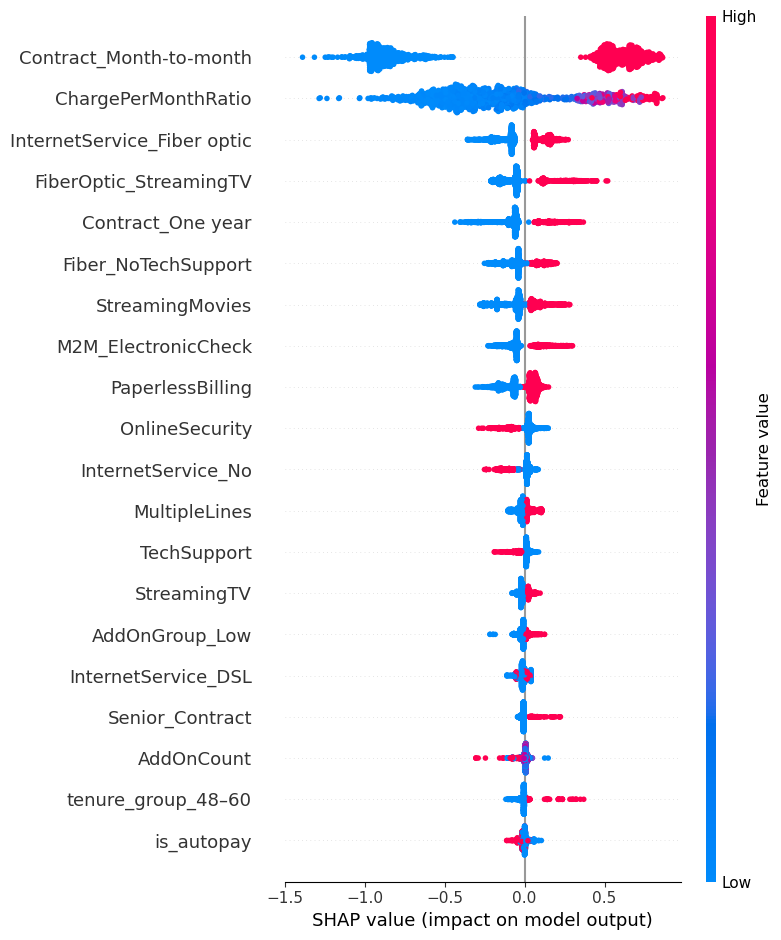

In [85]:
import shap

explainer = shap.Explainer(best_xgb)
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)
